# Fashion-MNIST 데이터 CNN을 통한 이미지 분류

-------------------------------------------------------------------------------------

본 과제에서는 Fashion-MNIST 데이터를 활용하여 CNN 모델을 구축하여 데이터를 학습시켜 모델을 평가하는 과정을 통하여 정확도 확인 및 잘못 분류된 이미지에 대한 분석을 진행한다.

- 1. Fashion-MNIST 데이터셋 로드 및 훈련 데이터, 테스트 데이터로 분할

- 2. 이미지 데이터의 형태 및 클레스 레이블을 시각적 탐색 및 분석 진행

- 3. CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

- 4. 모델 컴파일 및 손실 함수와 최적화 알고리즘 선택 및 구현

- 5. 훈련 데이터를 모델에 학습시키고 학습 과정의 손실과 정확도 모니터링을 통한 확인

- 6. 학습을 완료한 모델에 테스트 데이터를 통해 모델을 평가 후 최종 정확도 보고

- 7. 잘못된 분류 이미지 분석 및 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지 시각화 자료를 통해 확인 진행

총 7단계의 과정을 통해 진행된다.

-------------------------------------------------------------------------------------

# 작업 환경

-------------------------------------------------------------------------------------

- Python Version : 3.10.13


-------------------------------------------------------------------------------------


In [13]:
# 필요한 라이브러리 설치 및 환경 준비

# pytorchcv.py 파일을 다운
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py


%pip install torchvision # torchvision 라이브러리 설치
%pip install torchinfo # torchinfo 라이브러리 설치
%pip install pytorchcv # pytorchcv 라이브러리 설치


import torch #pytorch import 진행
import torch.nn as nn #신경망을 위한 nn 정의
import torchvision #torchvision
import matplotlib.pyplot as plt #시각화를 위한 pyplot
from torchinfo import summary #모델의 구조를 확인 위한 torchinfo
import numpy as np #numpy (배열 처리)

import pytorchcv # 상단에서 설치한 pytorchcv import

#pytorchcv에서 지원하는 함수들 목록
#train : 모델 학습 기능
#plot_result : 학습 결과를 그래프로 시각화
#plot_convolution : convolutional layer의 출력
#display_dataset : 데이터셋을 시각화해서 보여줌
from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset 

--2024-04-17 13:24:44--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.39K  --.-KB/s    in 0s      

2024-04-17 13:24:44 (18.5 MB/s) - ‘pytorchcv.py’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
#2. 이미지 데이터의 형태 및 클레스 레이블을 시각적 탐색 및 분석 진행



In [ ]:
#3. CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

In [ ]:
#4. 모델 컴파일 및 손실 함수와 최적화 알고리즘 선택 및 구현

In [ ]:
#5. 훈련 데이터를 모델에 학습시키고 학습 과정의 손실과 정확도 모니터링을 통한 확인

In [ ]:
#6. 학습을 완료한 모델에 테스트 데이터를 통해 모델을 평가 후 최종 정확도 보고

In [ ]:
#7. 잘못된 분류 이미지 분석 및 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지 시각화 자료를 통해 확인 진행

In [10]:
import torch.nn as nn
%pip install torchsummary
from torchsummary import summary

class OneConv(nn.Module): # Defines a new class called OneConv that inherits from PyTorch's nn.Module. nn.Module is the base class for all neural network modules in PyTorch
    def __init__(self): # This method initializes the OneConv class. The __init__ method is a special method in Python classes. It gets called when an object of the class is created
        super(OneConv, self).__init__() # This line calls the constructor of the superclass (nn.Module). This is necessary to properly initialize the inherited class, setting up internal mechanisms that are crucial for the model's training and inference operations in PyTorch
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # a 2D convolutional layer is defined and assigned to self.conv
        self.flatten = nn.Flatten() # This creates an instance of the Flatten layer and assigns it to self.flatten. The Flatten layer converts a multi-dimensional input into a 1D array. This is typically used to transition from convolutional layers to fully connected layers
        self.fc = nn.Linear(5184,10) # This line defines a fully connected (or linear) layer that is assigned to self.fc. The layer transforms an input of 5184 features to 10 features.

    def forward(self, x): # The forward method defines the forward pass of the module. x is the input tensor that passes through the model
        if x.dim() == 5 and x.size(2) == 1:  # Check for unexpected extra dimension
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # This line applies the defined convolutional layer self.conv to the input x, then applies the ReLU activation function to the output of the convolution
        x = self.flatten(x) # This line applies the self.flatten layer to the output of the ReLU activation, converting all the feature maps into a single long vector, which can be fed into fully connected layers
        x = nn.functional.log_softmax(self.fc(x),dim=1) # Applies the fully connected layer self.fc to the flattened vector x. The result is then passed through a log softmax function. log_softmax is a logarithmic version of the softmax function, which is used to compute probabilities for multi-class classification problems. The dim=1 argument specifies that the softmax should be applied to the second dimension, which corresponds to the class probabilities for each input in the batch

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv()

# Print the summary of the model
summary(net,input_size=(1,1,28,28))

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [7]:
import torch.nn as nn
%pip install torchsummary
from torchsummary import summary

class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        # 2D 합성곱 레이어를 정의합니다.
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5))
        
        # Flatten 레이어를 생성합니다.
        self.flatten = nn.Flatten()
        
        # 완전 연결 레이어를 정의합니다.
        self.fc = nn.Linear(5184, 10)

    def forward(self, x):
        # 입력 텐서의 차원을 확인하고, 예상치 못한 추가 차원이 있는지 확인합니다.
        if x.dim() == 5 and x.size(2) == 1:
            x = x.squeeze(2)
        
        # 합성곱 레이어와 ReLU 활성화 함수를 적용합니다.
        x = nn.functional.relu(self.conv(x))
        
        # Flatten 레이어를 통해 출력을 1차원 배열로 변환합니다.
        x = self.flatten(x)
        
        # 완전 연결 레이어와 log softmax 활성화 함수를 적용합니다.
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        
        return x

# 네트워크의 인스턴스를 생성합니다.
net = OneConv()

# 모델의 요약 정보를 출력합니다.
summary(net, input_size=(1, 1, 28, 28))


Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


Epoch  0, Train acc=0.949, Val acc=0.974, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.980, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.987, Val acc=0.976, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.979, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.990, Val acc=0.976, Train loss=0.000, Val loss=0.001


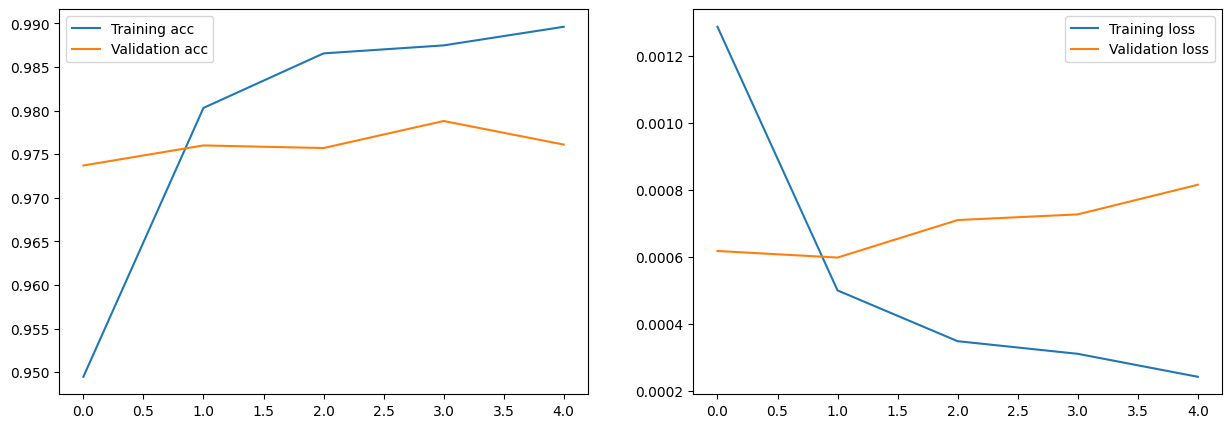

In [11]:
hist = train(net,train_loader,test_loader,epochs=5)
if hist is None:
    print("Training did not return any history.")
else:
    plot_results(hist)